<a href="https://colab.research.google.com/github/uzl/DySys-ML/blob/main/LorenzNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's consider the Lorenz system of differential equations.

\[
\begin{align*}
\frac{dx}{dt} &= \sigma(y - x), \\
\frac{dy}{dt} &= x(\rho - z) - y, \\
\frac{dz}{dt} &= xy - \beta z.
\end{align*}
\]

We will train a Neural Network to learn an update rule which advances the state space from $x_{k}$ to $x_{k+1}$, where $k$ denotes the state of the system at time $t_k$.

In [ ]:
import numpy as np
from scipy.integrate import odeint
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D
from tqdm import tqdm

# manual seed for reproducibility
torch.manual_seed(123)
np.random.seed(123)
# try to accelerate parallel computation in GPU if available
compute_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Dataset generation

We will create some sample data based on the Lorenz system  of differential equations. The Neural Network will try to lean the underlying pattern without the explicite equation.

In [ ]:
N = 100 # dataset sample size
dt = 0.01; T = 8
t = np.arange(0, T+dt, dt)  # (801,)

def lorenz_derivative(xyz, t_0, sigma=10, beta=8/3, rho=28):
  x, y, z = xyz
  return [sigma*(y-x), x*(rho-z)-y, x*y-beta*z]

init_cond = -15 + 30 * np.random.random((N, 3)) # (100, 3)
x_t = np.array([odeint(lorenz_derivative, x0_j, t) for x0_j in init_cond])

inp_x = np.array([x_t[j, :-1, :] for j in range(N)])  # (100, 800, 3): system at x_{k}
out_y = np.array([x_t[j, 1:, :] for j in range(N)])   # (100, 800, 3): system x_{k+1} advanced ∆t = 0.01

# Prepare data for pytorch
X = torch.from_numpy(inp_x).float().to(compute_device)
Y = torch.from_numpy(out_y).float().to(compute_device)

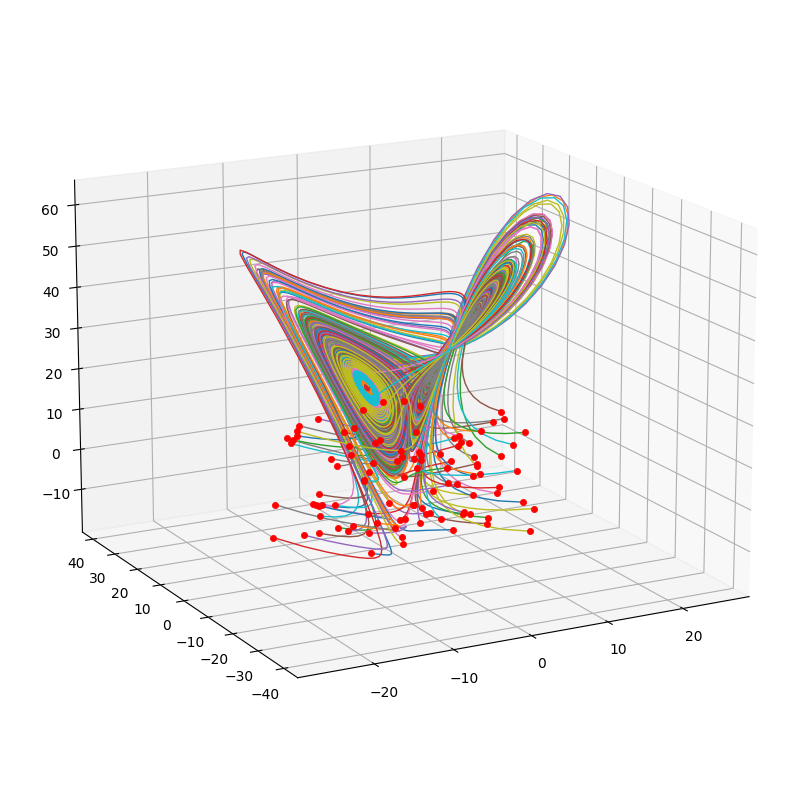

In [ ]:
# vizualize the generated dataset
fig,ax = plt.subplots(1,1, figsize=(10, 12), subplot_kw={'projection': '3d'})
for j in range(N):
  x, y, z = inp_x[j, :, :].T
  ax.plot(x, y, z,linewidth=1)
  ax.scatter(init_cond[j,0], init_cond[j,1], init_cond[j,2],color='r', linewidths=.5) # intial conditions

ax.view_init(16, -118)
plt.show()

Vizualization of Lorenz dynamical equations for 100 randomly chosen initial conditions (red circles). For the parameters σ = 10, ρ = 28, and β = 8/3, all trajectories collapse to an attractor.

<hr>

### Neural Network Architecture

We will create a simple feed forward neural network.

In [ ]:
# Neural Network Architecture
class LorenzNet(nn.Module):
  def __init__(self,):
    super().__init__()
    self.layer_1 = nn.Linear(3,10)
    self.layer_2 = nn.Linear(10, 10)
    self.layer_3 = nn.Linear(10, 3)

  def forward(self, x):
    x = F.sigmoid(self.layer_1(x))
    x = F.relu(self.layer_2(x))
    return self.layer_3(x)

lorenz_net = LorenzNet().to(compute_device)
optimizer = torch.optim.Adam(
    lorenz_net.parameters(), lr=0.001)
# Training Loop
for epoch in tqdm(range(5000)):
  optimizer.zero_grad()
  y_pred = lorenz_net(X)
  loss = F.mse_loss(y_pred, Y)
  loss.backward()   # computes the gradient
  optimizer.step()  # update weight

100%|██████████| 5000/5000 [00:13<00:00, 369.39it/s]


Testing prediction

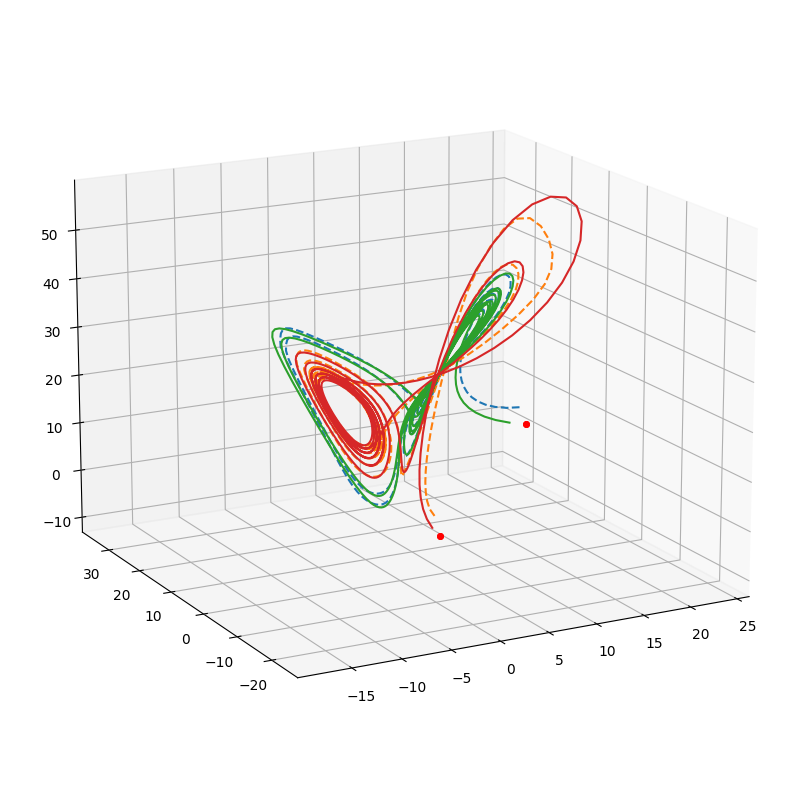

In [ ]:
np.random.seed(4) # for reproducibility
N = 2

test_init_cond = -15 + 30 * np.random.random((N, 3)) # (100, 3)
test_x_t = np.array([odeint(lorenz_derivative, x0_j, t) for x0_j in test_init_cond])

test_inp_x = np.array([test_x_t[j, :-1, :] for j in range(N)])  # (100, 800, 3): system at x_{k}
test_out_y = np.array([test_x_t[j, 1:, :] for j in range(N)])   # (100, 800, 3): system x_{k+1} advanced ∆t = 0.01

with torch.no_grad():
  test_pred_y = lorenz_net(torch.from_numpy(test_inp_x).float().to(compute_device)).cpu().numpy()


# vizualize the generated dataset
fig,ax = plt.subplots(1,1, figsize=(10, 12), subplot_kw={'projection': '3d'})
for j in range(N):
  x, y, z = test_pred_y[j, :, :].T
  ax.plot(x, y, z,linewidth=1.5, linestyle='--')
  # ax.scatter(x, y, z , linewidths=.1)
  ax.scatter(test_init_cond[j,0], test_init_cond[j,1], test_init_cond[j,2],color='r', linewidths=.5) # intial conditions


for j in range(N):
  x, y, z = test_out_y[j, :, :].T
  ax.plot(x, y, z,linewidth=1.5)
  # ax.scatter(x, y, z , linewidths=.1)
  ax.scatter(test_init_cond[j,0], test_init_cond[j,1], test_init_cond[j,2],color='r', linewidths=.5) # intial conditions


ax.view_init(16, -118)
plt.show()

The solid line is from Lorenz system, and the dotted line from NN prediction.
 The NN prediction looks remarkably close to the dynamical trajectory of the Lorenz model.

 This shows that the data used for training is capable of producing a high-quality nonlinear model mapping xk to xk+1



In [ ]:
lorenz_net.eval()
x = torch.from_numpy(test_inp_x).float().to(compute_device)

traced = torch.jit.trace(lorenz_net, x)
torch.jit.save(traced, 'lorenz_net.torchscript.pt')

lorenz_net.torchscript.svg

### Reference

Brunton, S. L., Kutz, J. N. (2019). Data-Driven Science and Engineering: Machine Learning, Dynamical Systems, and Control. Singapore: Cambridge University Press.